In [61]:
# Helper Scripts Run Notebook #

In [1]:
# Imports

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import models, datasets, transforms
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

from torchinfo import summary
from torch.optim.lr_scheduler import StepLR

from PIL import Image
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import (
    classification_report
    , confusion_matrix
    , ConfusionMatrixDisplay
)

from timeit import default_timer as timer
from tqdm import tqdm
import os
import random
import warnings
warnings.filterwarnings("ignore")

print("torch:", torch.__version__)

torch: 2.2.2


In [2]:
# Device selection (CUDA -> MPS -> CPU)
if torch.cuda.is_available():
    device = "cuda"  # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps"   # Apple Silicon
else:
    device = "cpu"   # CPU fallback

print("device:", device)

device: mps


In [4]:
from helper_scripts.t0rch_h3lp3r_0x00 import (
    train_model
    , evaluate_model
    , evaluate_model_with_cm_params
    , list_test_images
    , show_image_prediction
    , plot_training_curves_seaborn
    , plot_training_curves
)

In [ ]:
# pip install kagglehub

In [5]:
# os.cpu_count()
int(os.cpu_count() *0.25)
# max(0, min(2, (os.cpu_count() or 2) // 2))

4

In [6]:
# Load the data from the drive:

train_dir = "./cars_image_dataset/train/"
test_dir = "./cars_image_dataset/test/"

train_dir, test_dir

('./cars_image_dataset/train/', './cars_image_dataset/test/')

In [9]:
# For init pretrained backbone - EfficientNet_B2 (*For small "toy" sets, EfficientNet_B2 and ConvNeXt-Tiny are both strong.) If acc/loss is not great, swap to ConvNeXt-Tiny by uncommenting the alt block below.

# --- Default: EfficientNet_B2 ---
weights = models.EfficientNet_B2_Weights.IMAGENET1K_V1
model = models.efficientnet_b2(weights=weights)
preprocess = weights.transforms()

In [10]:
weights, preprocess

(EfficientNet_B2_Weights.IMAGENET1K_V1,
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [ ]:
# --- ALT: ConvNeXt-Tiny (optional swap) ---
# from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
# weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
# model = convnext_tiny(weights=weights)
# preprocess = weights.transforms()

In [11]:
# Use the preprocess transform for EfficientNet_B2 (preprocess)

num_workers=int(os.cpu_count() *0.25) 

train_dataset = datasets.ImageFolder(
    root=train_dir
    , transform=preprocess
)

test_dataset = datasets.ImageFolder(
    root=test_dir
    , transform=preprocess
)

train_loader = DataLoader(
    dataset=train_dataset
    , batch_size=32
    , shuffle=True
    , num_workers=num_workers # was 2, now trying 25% of cpu count (4)
)

test_loader = DataLoader(
    dataset=test_dataset
    , batch_size=32
    , shuffle=False
    , num_workers=num_workers # was 2, now trying 25% of cpu count (4)
)

len(train_dataset), len(test_dataset)

(3352, 813)

In [12]:
# Derive class names dynamically (no hardcoding)
class_names = train_dataset.classes
num_classes = len(class_names)
print("Number of classes:", num_classes)
print("Detected classes:", class_names)

Number of classes: 7
Detected classes: ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


In [13]:
num_classes, preprocess

(7,
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [31]:
### Take a peek at some of the data to get a feel for the shapes, batches, etc.

In [27]:
# get one batch
images, labels = next(iter(train_loader))

print("images.shape:", images.shape)   # e.g. torch.Size([32, 3, H, W])
print("labels.shape:", labels.shape)   # e.g. torch.Size([32])

images.shape: torch.Size([32, 3, 288, 288])
labels.shape: torch.Size([32])


In [17]:
import random
idx = random.randrange(len(train_dataset))
img, label = train_dataset[idx]
print("dataset sample shape:", img.shape)   # e.g. torch.Size([3, H, W])
print("label:", label)

dataset sample shape: torch.Size([3, 288, 288])
label: 1


In [29]:
# get a single img (random - by index int)

images, labels = next(iter(train_loader))
i = torch.randint(len(images), (1,)).item()   # random index in the batch
print(f"sample index: {i}")
print("single image shape:", images[i].shape)  # e.g. torch.Size([3, H, W])
print("single label:", labels[i].item())

sample index: 19
single image shape: torch.Size([3, 288, 288])
single label: 6


In [32]:
# Start building the model & hyperparams;

In [14]:
# UPDATED EffNetB2 --> w/ 2 add'l layers unfrozen;
# (Next option if not significant increase in metrix --> adjust preprocess: img size to 300 & batches of 16;)

model = model

for p in model.parameters():
    p.requires_grad = False

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Unfreeze last 2 blocks
n_unfreeze = 2
total_blocks = len(model.features)
for i in range(total_blocks - n_unfreeze, total_blocks):
    for p in model.features[i].parameters():
        p.requires_grad = True

model = model.to(device)

# Optimizer with two groups
backbone_params = [p for m in model.features[total_blocks - n_unfreeze:] for p in m.parameters() if p.requires_grad]
head_params = list(model.classifier.parameters())

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {"params": backbone_params, "lr": 1e-4, "weight_decay": 1e-4}
    , {"params": head_params,     "lr": 5e-4, "weight_decay": 5e-5},
])

# Keep your StepLR or switch to cosine
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [16]:
train_losses, train_accuracies = train_model(
    model=model
    , train_loader=train_loader
    , criterion=criterion
    , optimizer=optimizer
    , scheduler=scheduler
    , epochs=6
)

 17%|██████▌                                | 1/6 [01:23<06:55, 83.11s/it]

Epoch 1/6 | Loss: 1.2497 | Acc: 58.3532% | LR: 0.000100


 33%|█████████████                          | 2/6 [02:20<04:30, 67.70s/it]

Epoch 2/6 | Loss: 0.4779 | Acc: 87.7685% | LR: 0.000100


 50%|███████████████████▌                   | 3/6 [03:15<03:06, 62.26s/it]

Epoch 3/6 | Loss: 0.2672 | Acc: 93.0788% | LR: 0.000100


 67%|██████████████████████████             | 4/6 [04:12<02:00, 60.13s/it]

Epoch 4/6 | Loss: 0.1730 | Acc: 95.5251% | LR: 0.000100


 83%|████████████████████████████████▌      | 5/6 [05:08<00:58, 58.64s/it]

Epoch 5/6 | Loss: 0.1104 | Acc: 97.2554% | LR: 0.000080


100%|███████████████████████████████████████| 6/6 [06:05<00:00, 60.98s/it]

Epoch 6/6 | Loss: 0.0834 | Acc: 98.1205% | LR: 0.000080


In [17]:
import pandas as pd

# Build DataFrame from history (will code this in earlier in a later update;)
df_metrics = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1)
    , "Train Loss": train_losses
    , "Train Accuracy": train_accuracies
})

df_metrics.tail(3)

,Epoch,Train Loss,Train Accuracy
3,4,0.172960,95.525060
4,5,0.110421,97.255370
5,6,0.083396,98.120525


In [18]:
df_metrics['Train Loss'].min(), df_metrics['Train Accuracy'].max()

(0.08339598010736463, 98.12052505966588)

In [19]:
current_date = datetime.now().strftime("%Y-%m-%d")

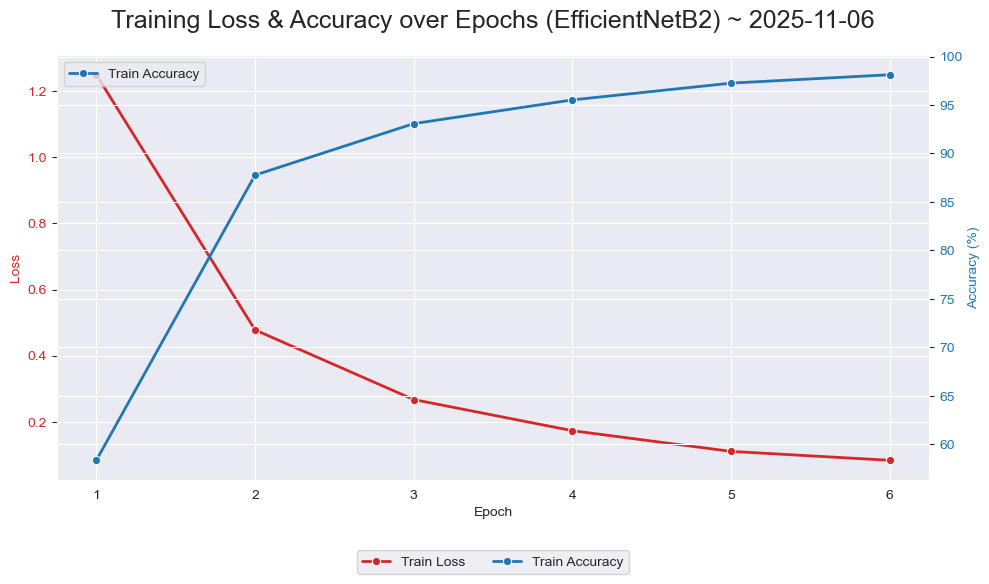

In [66]:
plot_training_curves_seaborn(
    df_metrics
    , x_col="Epoch"
    , loss_col="Train Loss"
    , acc_col="Train Accuracy"
    , title=f"Training Loss & Accuracy over Epochs (EfficientNetB2) ~ {current_date}"
)

In [21]:
# Running Test Loop on EfficientNet using our helper eval script (w/ built-in sklearn metrix options!)

test_acc, all_preds, all_labels = evaluate_model_with_cm_params(
    model=model
    , test_loader=test_loader
    , device=device
)

Test Accuracy: 95.0800%


In [ ]:
# We might be able to squeeze some better metrix out of this with a few more epochs!!!

In [23]:
%%time
### SECOND / FOLLOW-UP TRAINING RUN ("Retrain") ###

# EfficientNet_B2 Training Loop *** With tqdm progress bar AND stored loss/acc for plotting in next cell;

train_losses, train_accuracies = train_model(
    model=model
    , train_loader=train_loader
    , criterion=criterion
    , optimizer=optimizer
    , scheduler=scheduler
    , epochs=9
    , device=device
)

 11%|████▎                                  | 1/9 [00:54<07:19, 54.90s/it]

Epoch 1/9 | Loss: 0.0522 | Acc: 98.9558% | LR: 0.000080


 22%|████████▋                              | 2/9 [01:50<06:26, 55.23s/it]

Epoch 2/9 | Loss: 0.0491 | Acc: 98.8962% | LR: 0.000080


 33%|█████████████                          | 3/9 [02:45<05:31, 55.25s/it]

Epoch 3/9 | Loss: 0.0443 | Acc: 98.9558% | LR: 0.000080


 44%|█████████████████▎                     | 4/9 [03:40<04:35, 55.08s/it]

Epoch 4/9 | Loss: 0.0439 | Acc: 99.0155% | LR: 0.000064


 56%|█████████████████████▋                 | 5/9 [04:35<03:40, 55.01s/it]

Epoch 5/9 | Loss: 0.0390 | Acc: 99.1050% | LR: 0.000064


 67%|██████████████████████████             | 6/9 [05:31<02:45, 55.24s/it]

Epoch 6/9 | Loss: 0.0312 | Acc: 99.3735% | LR: 0.000064


 78%|██████████████████████████████▎        | 7/9 [06:26<01:50, 55.16s/it]

Epoch 7/9 | Loss: 0.0261 | Acc: 99.4928% | LR: 0.000064


 89%|██████████████████████████████████▋    | 8/9 [07:20<00:55, 55.02s/it]

Epoch 8/9 | Loss: 0.0283 | Acc: 99.4332% | LR: 0.000064


100%|███████████████████████████████████████| 9/9 [08:16<00:00, 55.12s/it]

Epoch 9/9 | Loss: 0.0231 | Acc: 99.4033% | LR: 0.000051
CPU times: user 2min 36s, sys: 1min 23s, total: 3min 59s
Wall time: 8min 16s


In [24]:
# Build another DataFrame from history (will code this in earlier in a later update;)

df_metrics_final = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1)
    , "Train Loss": train_losses
    , "Train Accuracy": train_accuracies
})

df_metrics_final.tail(3)

,Epoch,Train Loss,Train Accuracy
6,7,0.026132,99.492840
7,8,0.028266,99.433174
8,9,0.023064,99.403341


In [25]:
# Note - since it makes sense to append the epochs from both train loops rather than plotting separate append the two but tweek the latter to continue epochs chronologically(e.g., since df_metrics epochs are 1..6, df_metrics_final should be 7..15)

last_epoch = df_metrics['Epoch'].max()                # e.g. 6
df_metrics_final_shifted = df_metrics_final.copy()    # avoid mutating original
df_metrics_final_shifted['Epoch'] = df_metrics_final_shifted['Epoch'] + last_epoch

df_metrics_all = pd.concat([df_metrics, df_metrics_final_shifted], ignore_index=True)
df_metrics_all.tail(3)

,Epoch,Train Loss,Train Accuracy
12,13,0.026132,99.492840
13,14,0.028266,99.433174
14,15,0.023064,99.403341


In [38]:
from helper_scripts.t0rch_h3lp3r_0x00 import plot_training_curves

In [59]:
current_date = datetime.now().strftime("%Y-%m-%d")
current_date

'2025-11-06'

In [62]:
plot_training_curves(
    df_metrics_all
    , x_col="Epoch"
    , loss_col="Train Loss"
    , acc_col="Train Accuracy"
    , title=f"Training Loss & Accuracy over Epochs (EfficientNetB2) ~ {current_date}"
)

In [40]:
# Running final test loop on EfficientNetB2 unfrozen model:

test_acc2, all_preds, all_labels = evaluate_model_with_cm_params(
    model=model
    , test_loader=test_loader
    , device=device
)

Test Accuracy: 95.8180%


In [42]:
test_items, test_by_class = list_test_images(
    test_dir
    , class_names
)

print(f"Found {len(test_items)} test images across {len(class_names)} classes.")
for cls in class_names:
    print(f"  {cls:20s}: {len(test_by_class.get(cls, []))}")

Found 813 test images across 7 classes.
  Audi                : 199
  Hyundai Creta       : 67
  Mahindra Scorpio    : 75
  Rolls Royce         : 74
  Swift               : 102
  Tata Safari         : 106
  Toyota Innova       : 190


In [43]:
# Set up a 'saved_models' directory (if it doesnt already exist):
from datetime import datetime

# Derive model name automatically 
weights_str = str(weights) # 'EfficientNet_B2_Weights.IMAGENET1K_V1' 
# ^^^Need to update this in other scripts as I wont always be using 'eff'...

named_model = weights_str.split('_Weights')[0]  # 'EfficientNet_B2'

# Save directory setup
save_dir = "./saved_models/"
os.makedirs(save_dir, exist_ok=True)

# Add the current date to the filename
current_date = datetime.now().strftime("%Y%m%d")

# --- Build filename dynamically ---
model_save_path = os.path.join(
    save_dir
    , f"{named_model.lower()}_cars_7-class_{current_date}_unfrzn_lyrs_99trn_95tst.pth"
)
print(model_save_path)

./saved_models/efficientnet_b2_cars_7-class_20251105_unfrzn_lyrs_99trn_95tst.pth


In [44]:
# Save the trained model to .pth

# Save only the parameters
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to: {model_save_path}")

Model state_dict saved to: ./saved_models/efficientnet_b2_cars_7-class_20251105_unfrzn_lyrs_99trn_95tst.pth


In [89]:
from helper_scripts.t0rch_h3lp3r_0x00 import (
    train_model
    , evaluate_model
    , evaluate_model_with_cm_params
    , list_test_images
    , show_image_prediction
    , plot_training_curves_seaborn
#     , device
)

In [90]:
device

'mps'

In [91]:
test_items, test_by_class = list_test_images(
    test_dir
    , class_names
)

print(f"Found {len(test_items)} test images across {len(class_names)} classes.")
for cls in class_names:
    print(f"  {cls:20s}: {len(test_by_class.get(cls, []))}")

Found 813 test images across 7 classes.
  Audi                : 199
  Hyundai Creta       : 67
  Mahindra Scorpio    : 75
  Rolls Royce         : 74
  Swift               : 102
  Tata Safari         : 106
  Toyota Innova       : 190


In [92]:
# Show ONE truly random test image (from any class)

assert len(test_items) > 0, "No test images found."
rand_path, rand_true = random.choice(test_items)

In [84]:
show_image_prediction(img_path=rand_path, true_label=rand_true)

NameError: name 'preprocess' is not defined

In [93]:
# Show ONE truly random test image (from any class)

assert len(test_items) > 0, "No test images found."
rand_path, rand_true = random.choice(test_items)

show_image_prediction(
    img_path=rand_path
    , model=model
    , preprocess=preprocess
    , class_names=class_names
    , device=device
    , true_label=rand_true
)

TypeError: show_image_prediction() got an unexpected keyword argument 'model'

In [47]:
# --------------------------------------------------------------------------- #
# Your existing show_image_prediction(), extended to optionally accept true_label

from PIL import Image
import torch
import matplotlib.pyplot as plt

def show_image_prediction(
    img_path
    , true_label=None
):
    """
    Displays an image, model prediction, and full class probability table.
    Optionally prints the provided true_label for quick correctness check.
    """
    # Load and preprocess
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        pred_idx = int(probabilities.argmax().item())
        pred_class = class_names[pred_idx]
        pred_prob = float(probabilities[pred_idx].item() * 100.0)

    # Display image with prediction
    title_str = f"Predicted: {pred_class} ({pred_prob:.2f}%)"
    if true_label is not None:
        correctness = "CORRECT!" if pred_class == true_label else "FALSE!"
        title_str = f"{title_str} | True: {true_label} {correctness}"

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.title(title_str, fontsize=14, color='green')
    plt.show()

    # Print probability distribution below the image
    print("Class probabilities:")
    for i, cls in enumerate(class_names):
        prob = float(probabilities[i].item() * 100.0)
        mark = "True " if (true_label is not None and cls == true_label) else "     "
        star = "*" if i == pred_idx else " "
        print(f"{star} {mark}{cls:20s}: {prob:7.4f}%")

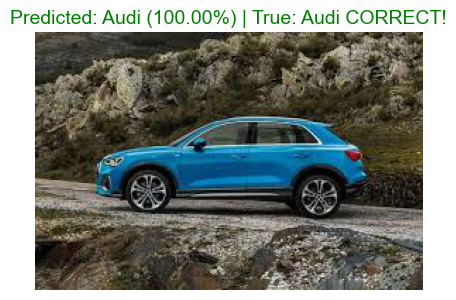

Class probabilities:
* True Audi                : 99.9997%
       Hyundai Creta       :  0.0000%
       Mahindra Scorpio    :  0.0000%
       Rolls Royce         :  0.0000%
       Swift               :  0.0000%
       Tata Safari         :  0.0002%
       Toyota Innova       :  0.0000%


In [48]:
# --------------------------------------------------------------------------- #
# Show ONE truly random test image (from any class)

assert len(test_items) > 0, "No test images found."
rand_path, rand_true = random.choice(test_items)
show_image_prediction(rand_path, true_label=rand_true)

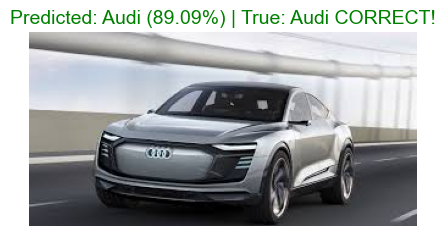

Class probabilities:
* True Audi                : 89.0886%
       Hyundai Creta       :  0.1419%
       Mahindra Scorpio    :  0.0049%
       Rolls Royce         :  2.8461%
       Swift               :  2.7311%
       Tata Safari         :  5.1731%
       Toyota Innova       :  0.0143%


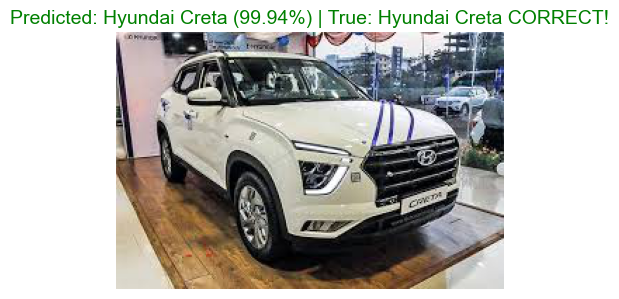

Class probabilities:
       Audi                :  0.0008%
* True Hyundai Creta       : 99.9406%
       Mahindra Scorpio    :  0.0554%
       Rolls Royce         :  0.0000%
       Swift               :  0.0000%
       Tata Safari         :  0.0023%
       Toyota Innova       :  0.0009%


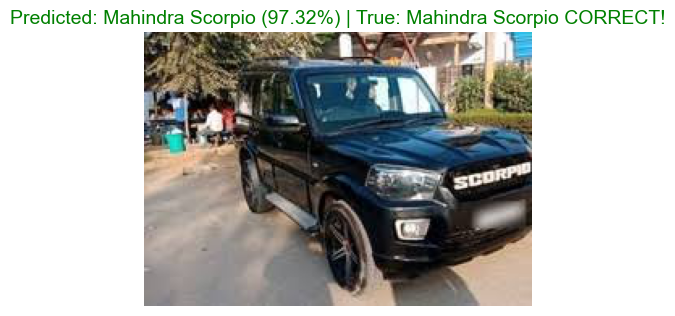

Class probabilities:
       Audi                :  0.4880%
       Hyundai Creta       :  1.2079%
* True Mahindra Scorpio    : 97.3211%
       Rolls Royce         :  0.3850%
       Swift               :  0.0520%
       Tata Safari         :  0.2409%
       Toyota Innova       :  0.3052%


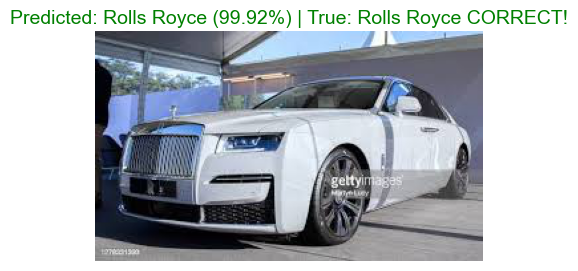

Class probabilities:
       Audi                :  0.0608%
       Hyundai Creta       :  0.0005%
       Mahindra Scorpio    :  0.0169%
* True Rolls Royce         : 99.9164%
       Swift               :  0.0012%
       Tata Safari         :  0.0007%
       Toyota Innova       :  0.0035%


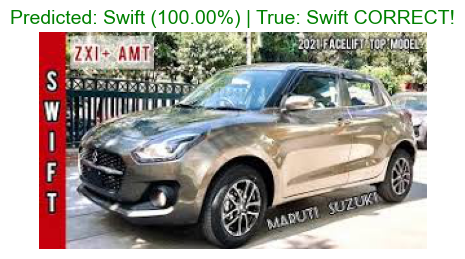

Class probabilities:
       Audi                :  0.0001%
       Hyundai Creta       :  0.0010%
       Mahindra Scorpio    :  0.0013%
       Rolls Royce         :  0.0000%
* True Swift               : 99.9965%
       Tata Safari         :  0.0002%
       Toyota Innova       :  0.0009%


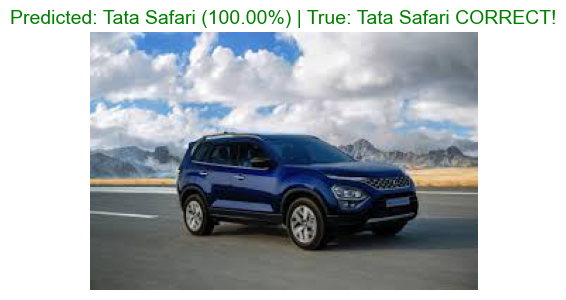

Class probabilities:
       Audi                :  0.0010%
       Hyundai Creta       :  0.0016%
       Mahindra Scorpio    :  0.0003%
       Rolls Royce         :  0.0001%
       Swift               :  0.0004%
* True Tata Safari         : 99.9961%
       Toyota Innova       :  0.0005%


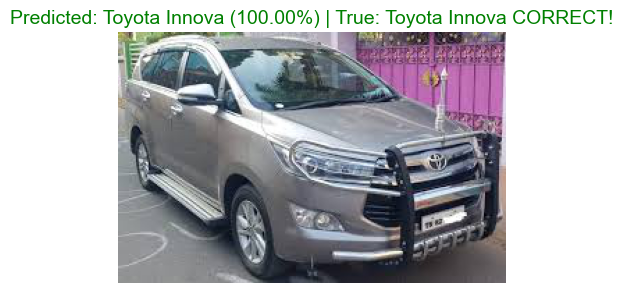

Class probabilities:
       Audi                :  0.0000%
       Hyundai Creta       :  0.0000%
       Mahindra Scorpio    :  0.0000%
       Rolls Royce         :  0.0000%
       Swift               :  0.0000%
       Tata Safari         :  0.0000%
* True Toyota Innova       : 99.9999%


In [49]:
# Show ONE random image PER CLASS (balanced peek)

for cls in class_names:
    candidates = test_by_class.get(cls, [])
    if not candidates:
        print(f"[skip] No images found for class: {cls}")
        continue
    img_path = random.choice(candidates)
    show_image_prediction(img_path, true_label=cls)

### NEXT --> BUILD CONFUSION MATRIX (text & plot), classification_report; ###

In [44]:
test_acc, all_preds, all_labels = evaluate_model_with_cm_params(
    model=model
    , test_loader=test_loader
    , device=device
)

Test Accuracy: 96.0640%


In [50]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


print(classification_report(all_labels, all_preds, digits=4))
confusion_matrix(all_labels, all_preds)

              precision    recall  f1-score   support

           0     0.9650    0.9698    0.9674       199
           1     0.9385    0.9104    0.9242        67
           2     0.9487    0.9867    0.9673        75
           3     0.9565    0.8919    0.9231        74
           4     0.9333    0.9608    0.9469       102
           5     0.9714    0.9623    0.9668       106
           6     0.9686    0.9737    0.9711       190

    accuracy                         0.9582       813
   macro avg     0.9546    0.9508    0.9524       813
weighted avg     0.9582    0.9582    0.9580       813



array([[193,   1,   0,   3,   1,   1,   0],
       [  1,  61,   1,   0,   2,   1,   1],
       [  0,   0,  74,   0,   1,   0,   0],
       [  5,   0,   1,  66,   1,   1,   0],
       [  0,   0,   1,   0,  98,   0,   3],
       [  0,   2,   0,   0,   0, 102,   2],
       [  1,   1,   1,   0,   2,   0, 185]])

<Figure size 1200x1200 with 0 Axes>

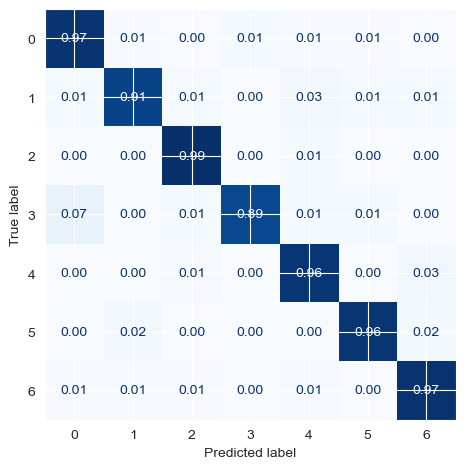

In [51]:
%matplotlib inline 
# ConfusionMatrixDisplay.from_predictions()

plt.figure(figsize=(12, 12)) 

disp = ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize="true", cmap="Blues", colorbar=False
)

# replace default annotations with two-decimal strings
for txt in plt.gca().texts: txt.set_text(f"{float(txt.get_text()):.2f}")
plt.tight_layout()
plt.show();

In [52]:
from torchinfo import summary

In [53]:
# get a batch shape for summary
images, labels = next(iter(train_loader))

input_shape = images.shape

In [54]:
input_shape

torch.Size([32, 3, 288, 288])

In [55]:
from torchinfo import summary
import torch

# Convert the input_shape to a tuple
input_size = input_shape

# Print a summary using torchinfo
summary(model=model,
        input_size=input_size  # Use the dynamically generated input_size
        , col_names=["input_size"
                     # , "output_size" # can have input_size or output_size (not both) due to size constraints
                     # ^ (cont.) I also find adjusting nb to '100% width' often breaks other things;
                     , "num_params"
                     , "trainable"
                    ]
        , col_width=20
        , row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   --                   False
│    │    └─MBConv (0)                                       [32, 32, 144, 144]   (1,448)              False
│    │    └─MB